In [1]:
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Data Gathering


In [2]:
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json


--2022-12-13 11:44:00--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.20.128, 108.177.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json’

sarcasm.json        100%[===================>]   5.38M  --.-KB/s    in 0.06s   

2022-12-13 11:44:00 (87.8 MB/s) - ‘sarcasm.json’ saved [5643545/5643545]



In [3]:
df = pd.read_json("./sarcasm.json")
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


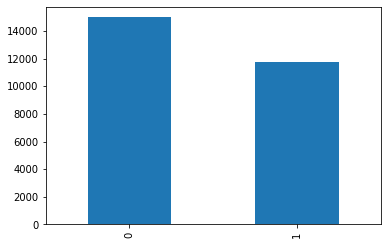

In [4]:
df["is_sarcastic"].value_counts().plot(kind="bar");


In [5]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2)
     

get_samples = lambda df : (df["headline"].values, df["is_sarcastic"].values)
train_data, train_labels = get_samples(train_df)
val_data, val_labels = get_samples(val_df)
     

Data Tokenization & Batchifying

Tokenization

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
     

VOCAB_SIZE = 10000
tokenizer = Tokenizer(VOCAB_SIZE, oov_token="")
tokenizer.fit_on_texts(train_data)

Create samples


In [7]:
pd.Series(train_data).apply(lambda x : len(x)).describe()


count    21367.000000
mean        60.836477
std         19.184557
min          7.000000
25%         48.000000
50%         61.000000
75%         73.000000
max        238.000000
dtype: float64

In [8]:
MAX_SEQ_LEN = 128
BUFFER_SIZE = 1024
BATCH_SIZE = 64

def create_tfds(tokenizer, X, y, padding=False):
  if padding:
    X = pad_sequences(tokenizer.texts_to_sequences(X), maxlen=MAX_SEQ_LEN, padding="post")
  return tf.data.Dataset.from_tensor_slices((X, y)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

ds_train = create_tfds(tokenizer, train_data, train_labels, padding=True)
ds_val = create_tfds(tokenizer, val_data, val_labels, padding=True)

Model Architecture


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, GlobalAveragePooling1D, Dense

EMBED_DIM = 64

model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM))
model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation="swish"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 644,225
Trainable params: 644,225
Non-trainable params: 0
__________________________________________________

In [10]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
     

callbacks = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=7)
model.fit(ds_train, epochs=20, validation_data=ds_val, callbacks=[callbacks]);

Epoch 1/20
334/334 [==============================] - 5s 10ms/step - loss: 0.6734 - acc: 0.5640 - val_loss: 0.6292 - val_acc: 0.6144
Epoch 2/20
334/334 [==============================] - 2s 6ms/step - loss: 0.5108 - acc: 0.7790 - val_loss: 0.4455 - val_acc: 0.7933
Epoch 3/20
334/334 [==============================] - 2s 6ms/step - loss: 0.3726 - acc: 0.8392 - val_loss: 0.3770 - val_acc: 0.8319
Epoch 4/20
334/334 [==============================] - 2s 6ms/step - loss: 0.3284 - acc: 0.8599 - val_loss: 0.3515 - val_acc: 0.8512
Epoch 5/20
334/334 [==============================] - 2s 5ms/step - loss: 0.2986 - acc: 0.8748 - val_loss: 0.3453 - val_acc: 0.8536
Epoch 6/20
334/334 [==============================] - 2s 5ms/step - loss: 0.2799 - acc: 0.8850 - val_loss: 0.3406 - val_acc: 0.8560
Epoch 7/20
334/334 [==============================] - 2s 5ms/step - loss: 0.2654 - acc: 0.8897 - val_loss: 0.3859 - val_acc: 0.8291
Epoch 8/20
334/334 [==============================] - 2s 5ms/step - loss: 0

In [11]:
model.evaluate(ds_val)


84/84 [==============================] - 0s 3ms/step - loss: 0.3597 - acc: 0.8557


[0.3596896827220917, 0.8556720614433289]

RNN

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, Dropout, Dense, SpatialDropout1D

EMBED_DIM = 64

model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM))
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(Bidirectional(GRU(64)))
model.add(Dense(32, activation="swish"))
model.add(Dropout(0.4))
model.add(Dense(1, activation="sigmoid"))
     

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
model.summary()
     

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          640000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        49920     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [14]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4)
model.fit(ds_train, epochs=5, validation_data=ds_val, callbacks=[callbacks]);
 

Epoch 1/5
334/334 [==============================] - 150s 448ms/step - loss: 0.3654 - acc: 0.8391 - val_loss: 0.3289 - val_acc: 0.8525
Epoch 2/5
334/334 [==============================] - 154s 460ms/step - loss: 0.2633 - acc: 0.8968 - val_loss: 0.3241 - val_acc: 0.8585
Epoch 3/5
334/334 [==============================] - 158s 473ms/step - loss: 0.2095 - acc: 0.9182 - val_loss: 0.3262 - val_acc: 0.8643
Epoch 4/5
334/334 [==============================] - 163s 488ms/step - loss: 0.1789 - acc: 0.9308 - val_loss: 0.3462 - val_acc: 0.8645
Epoch 5/5
334/334 [==============================] - 165s 493ms/step - loss: 0.1984 - acc: 0.9261 - val_loss: 0.3808 - val_acc: 0.8568


In [15]:
model.evaluate(ds_val)


84/84 [==============================] - 10s 117ms/step - loss: 0.3808 - acc: 0.8568


[0.3807990252971649, 0.8567951917648315]

Transfer learning vs pretrained embedding


In [16]:
ds_train = create_tfds(tokenizer, train_data, train_labels, padding=False)
ds_val = create_tfds(tokenizer, val_data, val_labels, padding=False)
     

import tensorflow_hub as hub
embedding_url = "https://tfhub.dev/google/universal-sentence-encoder/4"

model = Sequential()
model.add(hub.KerasLayer(embedding_url, input_shape=(), dtype=tf.string, trainable=True))
model.add(Dense(64, activation="swish"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_4 (Dense)             (None, 64)                32832     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 256,830,721
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
     

callbacks = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
model.fit(ds_train, epochs=1, validation_data=ds_val, callbacks=[callbacks]);
     

334/334 [==============================] - 331s 935ms/step - loss: 0.3476 - acc: 0.8472 - val_loss: 0.3070 - val_acc: 0.8624


In [20]:
model.evaluate(ds_val)


84/84 [==============================] - 1s 16ms/step - loss: 0.3070 - acc: 0.8624


[0.30696603655815125, 0.8624110817909241]